In [2]:
# import some basic libraries
import os
import pandas as pd
import seaborn as sns
%matplotlib inline

# 1. Basic Usage Guide

`pymer4` comes with sample data for testing purposes which we'll utilize for most of the tutorials.
This sample data has: 

- Two kinds of dependent variables: *DV* (continuous), *DV_l* (dichotomous)
- Three kinds of independent variables: *IV1* (continuous), *IV2* (continuous), *IV3* (categorical)
- One grouping variable for multi-level modeling: *Group*.

Let's check it out below:



In [3]:
# import utility function for sample data path
from pymer4.utils import get_resource_path

# Load and checkout sample data
df = pd.read_csv(os.path.join(get_resource_path(), 'sample_data.csv'))
df.head()

,Group,IV1,DV_l,DV,IV2,IV3
0,1,20.0,0,7.936508,4.563492,0.5
1,1,20.0,0,15.277778,0.000000,1.0
2,1,20.0,1,0.000000,0.000000,1.5
3,1,20.0,1,9.523810,0.000000,0.5
4,1,12.5,0,0.000000,0.000000,1.0


Standard regression models
------------------------------------
Fitting a standard regression model is accomplished using the`Lm` model class in `pymer4`. All we need to do is initialize a model with a formula, some data, and call its `.fit()` method. 

By default the output of `.fit()` has been formated to be a blend of `summary()` in R and `.summary()` from [statsmodels](http://www.statsmodels.org/dev/index.html/). This includes metadata about the model, data, and overall fit as well as estimates and inference results of model terms.  



In [3]:
# Import the linear regression model class
from pymer4.models import Lm

# Initialize model using 2 predictors and sample data
model = Lm('DV ~ IV1 + IV2', data=df)

# Fit it
model.fit()

Formula: DV~IV1+IV2

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 564	 R^2: 0.512	 R^2_adj: 0.510

Log-likelihood: -2527.681 	 AIC: 5061.363	 BIC: 5074.368

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,1.657,-4.107,7.422,2.935,561,0.565,0.573,
IV1,0.334,-0.023,0.690,0.181,561,1.839,0.066,.
IV2,0.747,0.686,0.807,0.031,561,24.158,0.000,***


All information about the model as well as data, residuals, estimated coefficients, etc are saved as attributes and can be accessed like this: 



In [5]:
# Print model AIC
model.AIC

5061.3629635837815

In [6]:
# Look at residuals (just the first 10)
model.residuals[:10]

array([-3.79994762,  6.94860187, -8.32917613,  1.19463387, -5.8271851 ,
       -6.88457421,  0.40673658,  9.77173122, -7.33135842, -7.37107236])

A copy of the dataframe used to estimate the model with added columns for residuals and fits are are available at `model.data`. Residuals and fits can also be directly accessed using `model.residuals` and `model.fits` respectively



In [7]:
# Look at model data
model.data.head()

,Group,IV1,DV_l,DV,IV2,IV3,fits,residuals
0,1,20.0,0,7.936508,4.563492,0.5,11.736456,-3.799948
1,1,20.0,0,15.277778,0.000000,1.0,8.329176,6.948602
2,1,20.0,1,0.000000,0.000000,1.5,8.329176,-8.329176
3,1,20.0,1,9.523810,0.000000,0.5,8.329176,1.194634
4,1,12.5,0,0.000000,0.000000,1.0,5.827185,-5.827185


This makes it easy to assess overall model fit visually, for example using [seaborn](https://seaborn.pydata.org/)



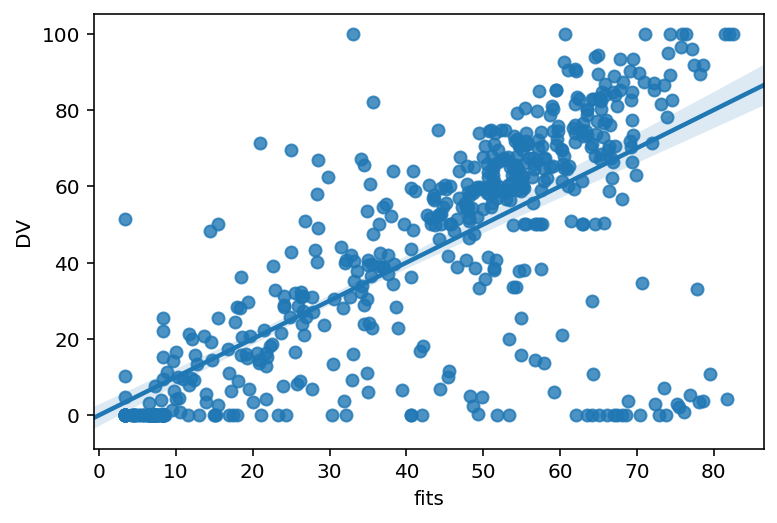

In [9]:
# plot model predicted values against true values
sns.regplot(x='fits', y='DV', data=model.data, fit_reg=True)

## Robust and WLS estimation

`Lm` models can also perform inference using robust-standard errors or perform weight-least-squares (experimental feature) for models with categorical predictors (equivalent to Welch's t-test).



In [10]:
# Refit previous model using robust standard errors
model.fit(robust='hc1')

Formula: DV~IV1+IV2

Family: gaussian	 Estimator: OLS

Std-errors: robust (hc1)	CIs: standard 95%	Inference: parametric 

Number of observations: 564	 R^2: 0.512	 R^2_adj: 0.510

Log-likelihood: -2527.681 	 AIC: 5061.363	 BIC: 5074.368

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,1.657,-3.429,6.744,2.590,561,0.640,0.522,
IV1,0.334,-0.026,0.693,0.183,561,1.823,0.069,.
IV2,0.747,0.678,0.815,0.035,561,21.444,0.000,***


In [11]:
# Since WLS is only supported with 2 groups for now, filter the data first
df_two_groups = df.query("IV3 in [0.5, 1.0]").reset_index(drop=True)

# Fit new a model using a categorical predictor with unequal variances (WLS)
model = Lm('DV ~ IV3', data=df_two_groups)
model.fit(weights='IV3')

Formula: DV~IV3

Family: gaussian	 Estimator: WLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 376	 R^2: 0.999	 R^2_adj: 0.999

Log-likelihood: -532.518 	 AIC: 1069.036	 BIC: 1076.896

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,45.647,35.787,55.507,5.015,373.483,9.103,0.000,***
IV3,-2.926,-15.261,9.410,6.273,373.483,-0.466,0.641,


Multi-level models
----------------------------
Fitting a multi-level model works similarly and actually just calls `lmer` or `glmer` in R behind the scenes. The corresponding output is also formatted to be very similar to output of`summary()` in R.



In [4]:
# Import the lmm model class
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts and slopes
model = Lmer('DV ~ IV2 + (IV2|Group)', data=df)

# Fit it; we're using the optional old_optimizer argument because this particular model
# fails to converge with lmer's new optimizer
model.fit(old_optimizer=True)

Formula: DV~IV2+(IV2|Group)

Family: gaussian	 Inference: parametric

Number of observations: 564	 Groups: {'Group': 47.0}

Log-likelihood: -2249.281 	 AIC: 4498.562

Random effects:

                 Name      Var     Std
Group     (Intercept)  203.495  14.265
Group             IV2    0.136   0.369
Residual               121.534  11.024

               IV1  IV2   Corr
Group  (Intercept)  IV2 -0.585

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.301,4.805,15.797,2.804,20.178,3.674,0.001,**
IV2,0.682,0.556,0.808,0.064,42.387,10.597,0.000,***


Similar to `Lm` models, `Lmer` models save details in model attributes and have additional methods that can be called using the same syntax as described above. 



In [13]:
# Get population level coefficients
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.301100,4.805668,15.796531,2.803843,20.179204,3.673922,1.488319e-03,**
IV2,0.682114,0.555978,0.808249,0.064356,42.403409,10.599062,1.705107e-13,***


In [14]:
# Get group level coefficients (just the first 5)
# Each row here is a unique intercept and slope
# which vary because we parameterized our rfx that way above
model.fixef.head(5)

,(Intercept),IV2
1,4.482146,0.885106
2,17.992303,0.622120
3,8.707070,0.838036
4,10.145435,0.865318
5,10.070328,0.182142


In [15]:
# Get group level deviates from population level coefficients (i.e. rfx)
model.ranef.head(5)

,(Intercept),IV2
1,-5.818953,0.202992
2,7.691203,-0.059994
3,-1.594030,0.155922
4,-0.155665,0.183204
5,-0.230772,-0.499972


`Lmer` models also have some basic plotting abilities that`Lm` models do not



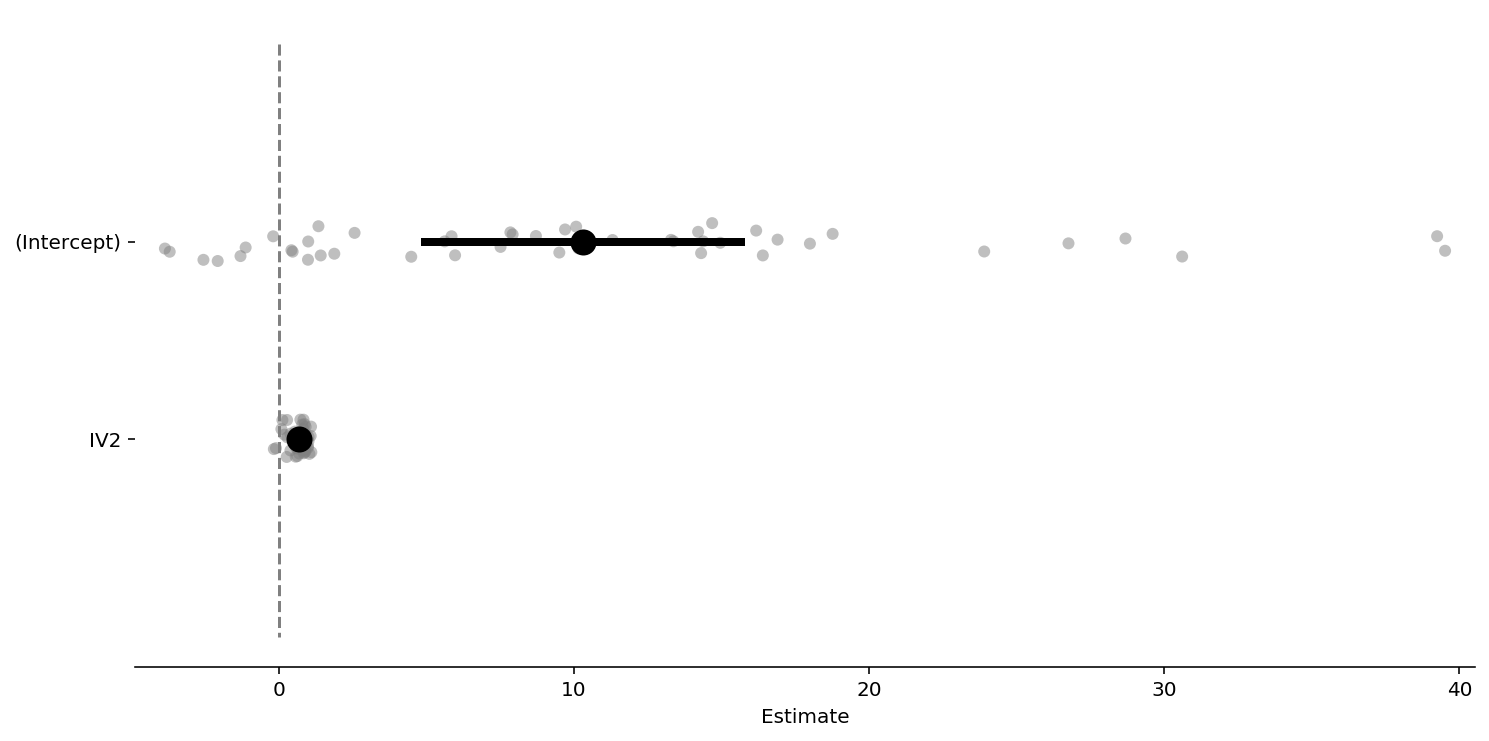

In [16]:
# Visualize coefficients with group/cluster fits overlaid ("forest plot")
model.plot_summary()

Plot coefficients for each group/cluster as separate regressions



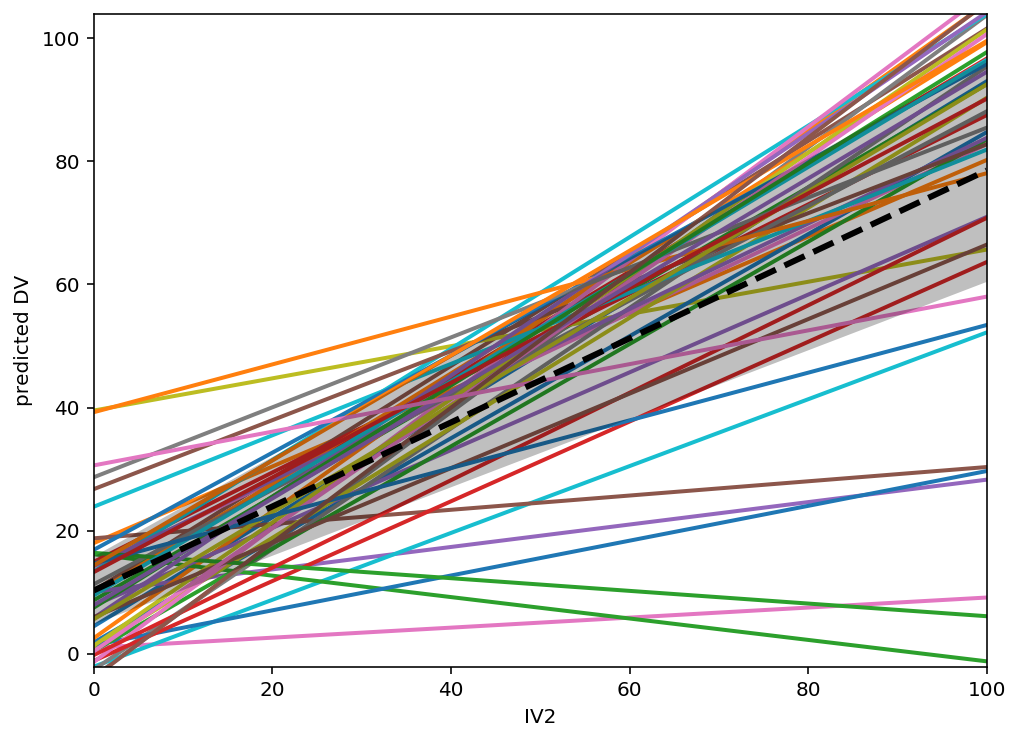

In [17]:
model.plot('IV2', plot_ci=True, ylabel='predicted DV')

Because`Lmer` models rely on R, they have also some extra arguments to the`.fit()` method for controlling things like optimizer behavior, as well as additional methods such for post-hoc tests and ANOVAs. See tutorial 2 for information about this functionality.



## Two-stage summary statistics models

Fitting `Lm2` models are also very similar



In [18]:
# Import the lm2 model class
from pymer4.models import Lm2

# This time we use the 'group' argument when initializing the model
model = Lm2('DV ~ IV2', group='Group', data=df)

# Fit it
model.fit()

Formula: DV~IV2

Family: gaussian

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 564	 Groups: {'Group': 47}

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,14.240,4.891,23.589,4.644,46,3.066,0.004,**
IV2,0.614,0.445,0.782,0.084,46,7.340,0.000,***


Like`Lmer` models, `Lm2` models also store group/cluster level estimates and have some basic plotting functionality



In [19]:
# Get group level coefficients, just the first 5 
model.fixef.head(5)

,Intercept,IV2
Group,,
1,3.039903,1.781832
2,23.388350,0.524852
3,4.904321,0.919913
4,23.304669,0.719425
5,18.378387,-0.256136


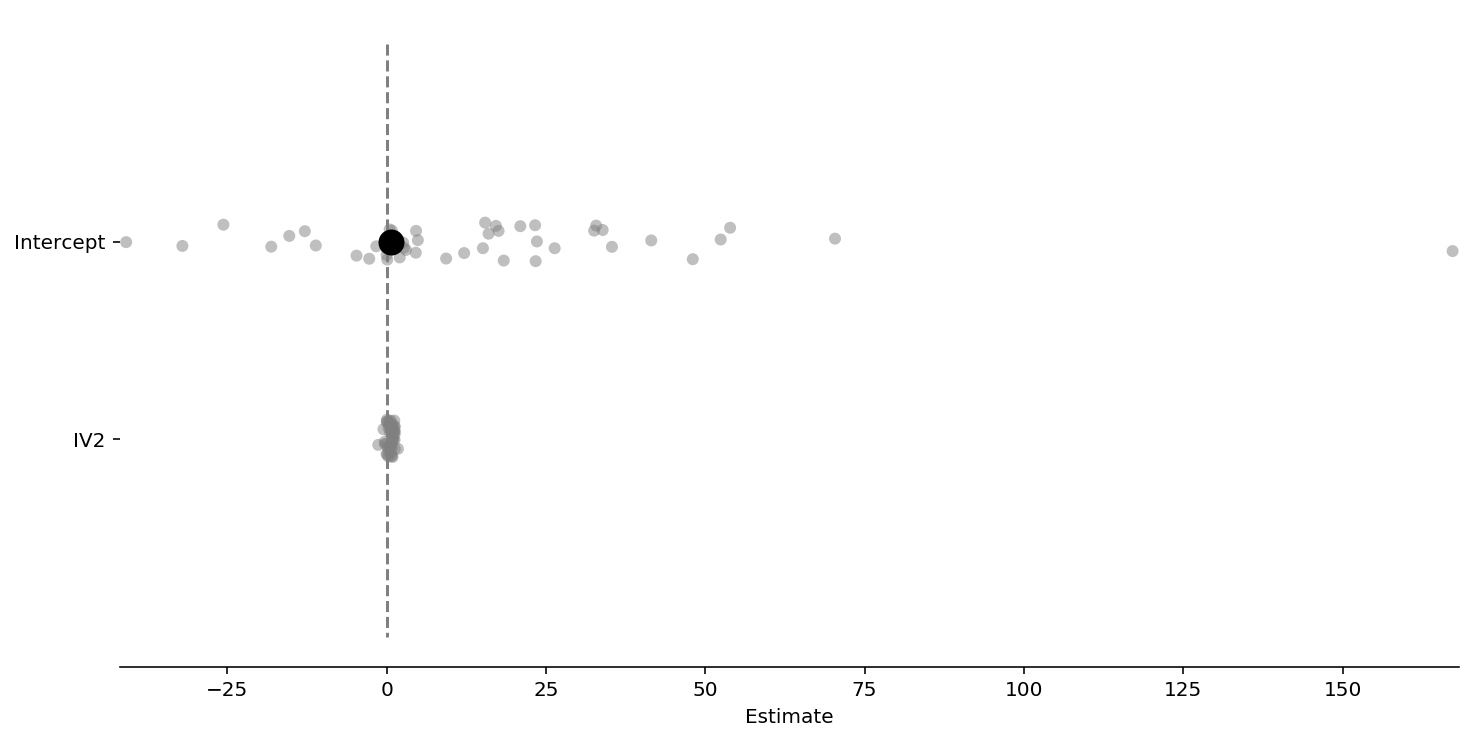

In [20]:
# Visualize coefficients with group/cluster fits overlaid ("forest plot")
model.plot_summary()

Model Persistence
-----------------
All pymer4 models can be saved and loaded from disk. Doing so will persist *all* model attributes and data i.e. anything accessible with the '.' syntax. Models are saved and loaded using the [HDF5 format](https://support.hdfgroup.org/HDF5/whatishdf5.html/) using the [deepdish](https://deepdish.readthedocs.io/en/latest/) python library. This ensures near universal accesibility on different machines and operating systems. Therefore all filenames must end with `.h5` or `.hdf5`. For `Lmer` models, an additional file ending in `.rds` will be saved in the same directory as the HDF5 file. This is the R model object readable in R using `readRDS()`.

To persist models you can use the dedicated `save_model()` and `load_model()` functions from the`pymer4.io` module



In [21]:
# Import functions
from pymer4.io import save_model, load_model
# Save the Lm2 model above
save_model(model, 'mymodel.h5')
# Load it back up
model = load_model('mymodel.h5')
# Check that it looks the same 
print(model)

pymer4.models.Lm2(fitted=True, formula=DV~IV2, family=gaussian, group=Group)


Wrap Up
-------
This was a quick overview of the 3 major model classes in`pymer4`. However, it's highly recommended to check out the API to see *all* the features and options that each model class has including things like permutation-based inference (`Lm` and `Lm2` models) and fine-grain control of optimizer and tolerance settings (`Lmer` models). 

